## Part 1: MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 255$) to  black ($=0$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.

In [2]:
%pylab inline
import torch
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


# Load and plot
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, label) in enumerate(train_loader_plot):
    plt.imshow(data.view(1,28,28).squeeze().numpy(), cmap='gray')
    plt.title('Label: ' + str(label.numpy()))
    plt.show()
    if batch_idx == 20:
        break


Populating the interactive namespace from numpy and matplotlib


URLError: <urlopen error [Errno -2] Name or service not known>

In [121]:
import os
import numpy as np
from PIL import Image

# training_normal = pathlib.Path('../Downloads/chest_xray/train/NORMAL').glob('*.jpeg')
# training_pneumonia = pathlib.Path('../Downloads/chest_xray/train/PNEUMONIA').glob('*.jpeg')
# im_path = training_normal_sorted[45]
# im = imageio.imread(str(im_path))

def get_images (directory, batch_size, label):
    images = []
    training = os.listdir(directory)
    for batch_idx, img_path in enumerate(training):
        if img_path.endswith('.jpeg'):
            img = Image.open(directory + '/' + img_path)
            resize = transforms.Resize((100, 100))
            gray = transforms.Grayscale()
            tensor = transforms.ToTensor()
            images.append((tensor(gray(resize(img))), torch.tensor(label)))
        if batch_idx==batch_size-1:
            break
            
    return images

In [122]:
train_normal = get_images('../Downloads/chest_xray/train/NORMAL', 100, 0)

In [123]:
train_pneumonia = get_images('../Downloads/chest_xray/train/PNEUMONIA', 100, 1)

In [124]:
train_data_xray = train_normal + train_pneumonia

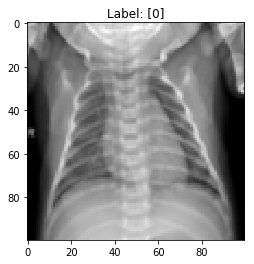

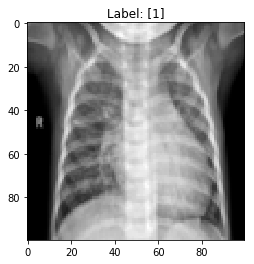

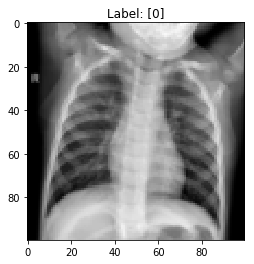

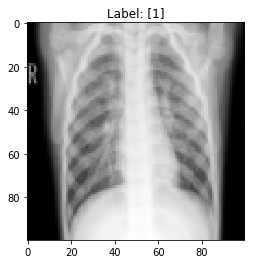

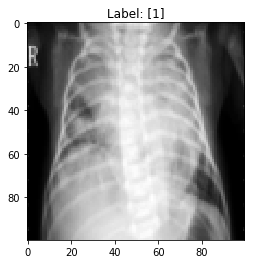

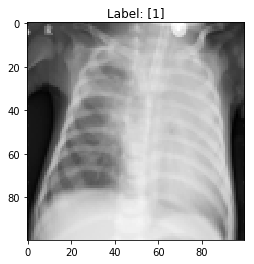

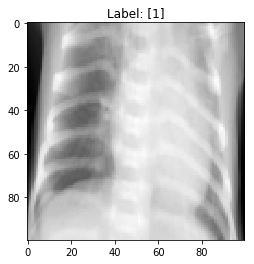

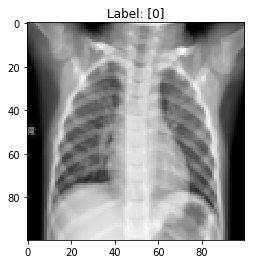

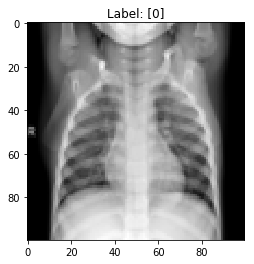

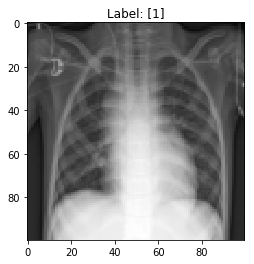

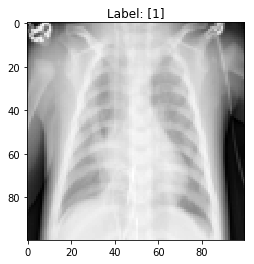

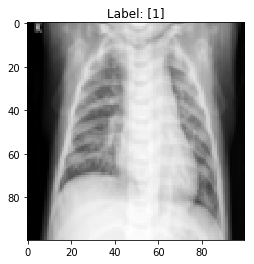

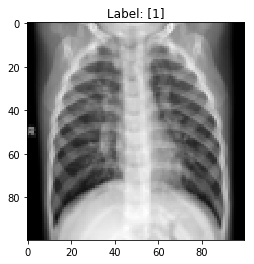

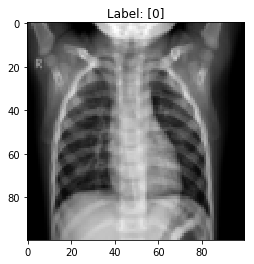

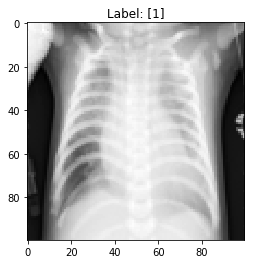

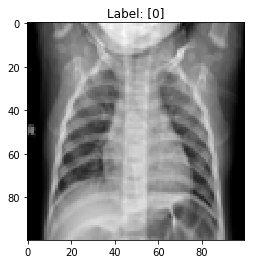

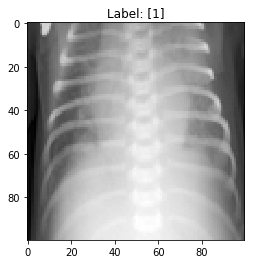

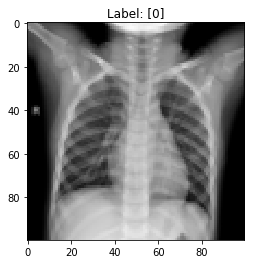

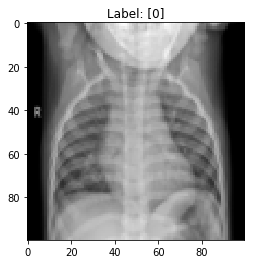

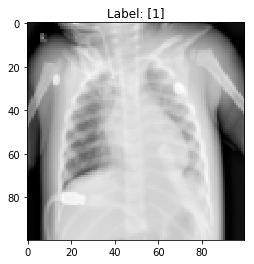

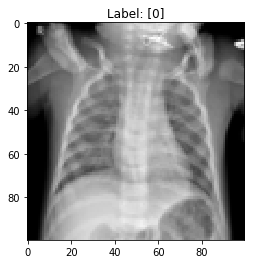

In [126]:
train_loader_plot = torch.utils.data.DataLoader(train_data_xray,
                                           batch_size=1, shuffle=True, **{})

for batch_idx, (data, label) in enumerate(train_loader_plot):
    plt.imshow(data.view(1, 100, 100).squeeze().numpy(), cmap='gray')
    plt.title('Label: ' + str(label.numpy()))
    plt.show()
    if batch_idx == 20:
        break

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(x, z)$ over observed variables $ x$ and latent variables $ z$. Here we distinguish the decoder part, $p( x |  z) p( z)$ and an encoder part $q( z |  x)$. A lower bound on the log marginal likelihood $\log p( x)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q( z|  x)$. This lower bound is then optimized to fit the model to the data. 

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log likelihood of a Bernoulli distribution and Kullback–Leibler divergence.

### 2.1.1 Negative Log Likelihood
The negative negative log likelihood of a Bernoulli distribution is defined as,

 \begin{align}
- \big(\sum_i^D  x_i \log \hat{ x_i} + (1 −  x_i) \log(1 − \hat{ x_i})\big).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Fill in the loss using PyTorch functions, e.g. torch.sum().

In [66]:
def log_bernoulli_loss(x_hat, x):
    loss = -torch.sum(x*torch.log(x_hat) + (1-x)*torch.log(1-x_hat))
    return loss

### 2.1.2 Negative Kullback–Leibler divergence
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(z)||p(z))$ that can often be calculated analytically. In the VAE we assume $q = N(z, \mu, \sigma^2I)$ - a Gaussian with a diagonal covariance matrix - and $p = N(z, 0, I)$. In this case the KL is given (up to a constant) by,

\begin{align}
D_{KL}(q(z)||p(z)) = -0.5 \sum_i^L(1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2).
\end{align}

Now implement the equation above in PyTorch. Since it will be convinient later assume your inputs are $\mu$ and $\log \sigma^2$, instead of just $\sigma$.

In [67]:
def KL_loss(mu, log_var):
    loss = -0.5*torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return loss

### 2.1.3 Putting the losses together
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two L dimensional vectors `mu` and `logvar` and returns the final loss.

In [127]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 10000), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [69]:
def loss_function1(x_hat, x, mu, logvar):
    LBL = log_bernoulli_loss(x_hat, x)
    KLD = KL_loss(mu, logvar)
    
    return LBL + KLD

### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $ x$ to latent variables $ z$) and the decoder (latent variables $ z$ to images $ x$). The encoder is using 3 fully-connected layers, whereas the decoder is using 2 fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [128]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        embed_x = F.relu(self.fc1(x))
        mu = self.fc21(embed_x)
        logvar = self.fc22(embed_x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        z = mu + torch.exp(0.5*logvar) * torch.randn_like(logvar)
        return z

    def decode(self, z):
        decode_z = F.relu(self.fc3(z))
        x_hat = torch.sigmoid(self.fc4(decode_z))
        return x_hat

    def forward(self, x):
        x = x.view(-1, 10000)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`.

In [71]:
def encode(self, x):
    embed_x = F.relu(self.fc1(x))
    mu = self.fc21(embed_x)
    logvar = self.fc22(embed_x)
    return mu, logvar


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $z$ that is drawn from a distribution $q(z|x)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. In the case of a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
z = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$, hint: you can use torch.randn_like() here to get \epsilon.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $z = \mu + \sigma \odot \epsilon$.


In [72]:
def reparameterize(self, mu, logvar):
    z = mu + torch.exp(0.5*logvar) * torch.randn_like(logvar)
    return z


### 2.5 Decoding
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [73]:
def decode(self, z):
    decode_z = F.relu(self.fc3(z))
    x_hat = torch.sigmoid(self.fc4(decode_z))
    return x_hat


### 2.6 Forward pass
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $x$ into latent space $z$, the reparameterization of $z$ and the decoding of $z$ into an image $x$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [129]:
def forward(self, x):
    x = x.view(-1, 10000)
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    return x_hat, mu, logvar


### 2.7 Training
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [130]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 10000), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [133]:
# Hyperparameters
fc1_dims=(10000, 1000)
fc21_dims=(1000, 50)
fc22_dims=(1000, 50)
fc3_dims=(50, 1000)
fc4_dims=(1000, 10000)
lr = 0.001
batch_size = 5
epochs = 10


Run the box below to train the model using the hyperparameters you entered above.

In [134]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data_xray,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/200 (0%)]	Loss: 7009.674316
====> Epoch: 1 Average loss: 6333.1133
Train Epoch: 2 [0/200 (0%)]	Loss: 6080.049805
====> Epoch: 2 Average loss: 6116.9468
Train Epoch: 3 [0/200 (0%)]	Loss: 6059.448242
====> Epoch: 3 Average loss: 6069.1323
Train Epoch: 4 [0/200 (0%)]	Loss: 5912.903320
====> Epoch: 4 Average loss: 6045.8687
Train Epoch: 5 [0/200 (0%)]	Loss: 6035.036133
====> Epoch: 5 Average loss: 6037.2285
Train Epoch: 6 [0/200 (0%)]	Loss: 6118.949219
====> Epoch: 6 Average loss: 6008.1812
Train Epoch: 7 [0/200 (0%)]	Loss: 5966.628906
====> Epoch: 7 Average loss: 5991.0024
Train Epoch: 8 [0/200 (0%)]	Loss: 5777.456055
====> Epoch: 8 Average loss: 5965.4717
Train Epoch: 9 [0/200 (0%)]	Loss: 6019.363281
====> Epoch: 9 Average loss: 5954.0596
Train Epoch: 10 [0/200 (0%)]	Loss: 5948.678223
====> Epoch: 10 Average loss: 5949.0464


Run the box below to check if the model you trained above is able to correctly reconstruct images.

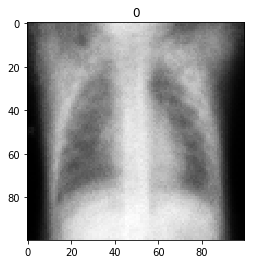

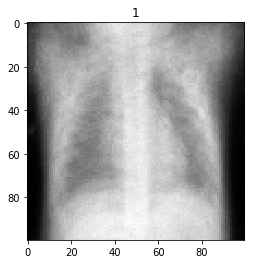

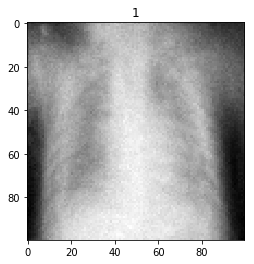

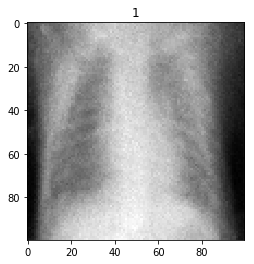

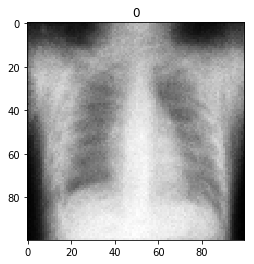

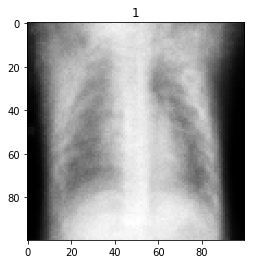

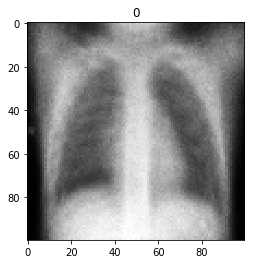

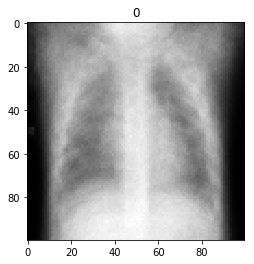

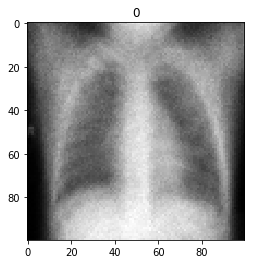

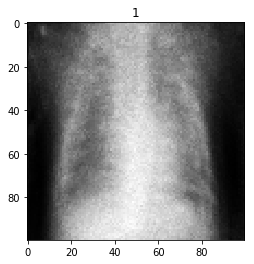

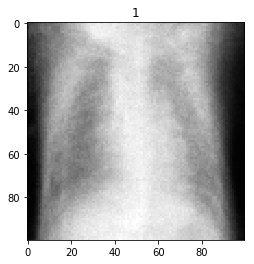

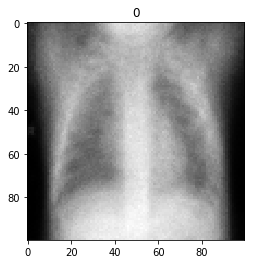

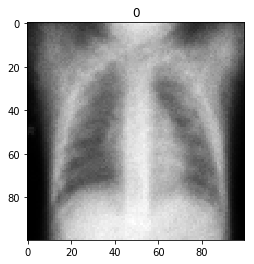

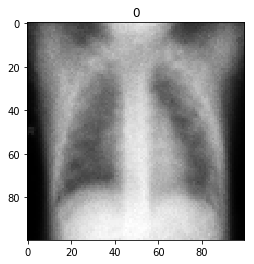

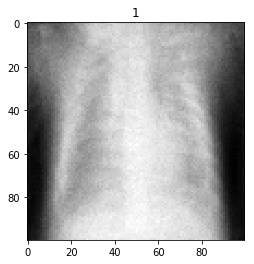

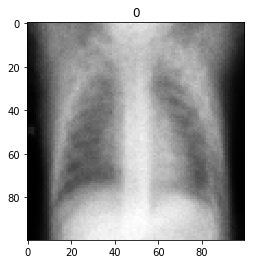

In [136]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_xray,
                                           batch_size=1, shuffle=True, **{})

for batch_idx, (data, label) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,100,100).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % label)
    plt.show()
    if batch_idx == 15:
        break
